# Landcover Pipeline
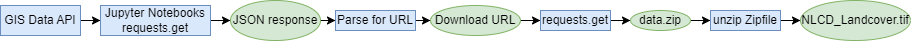

###### Credits:ChatGPT and Draw.io

## Import Statements

In [9]:
#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import locale
locale.setlocale(locale.LC_ALL, '')

import requests
import os
import arcpy
import zipfile
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import json

## Download Landcover Data

In [10]:
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
file_path_db = file_path + '\\MN_Geo_Data'
arcpy.env.workspace = file_path_db

#current working directory
current_directory = os.getcwd()
#creates path for data
Mn_GeoName = os.path.join(current_directory, "MN_data.zip")


#URL of API
json_url = 'https://gisdata.mn.gov/api/3/action/package_show?id=biota-landcover-nlcd-mn-2019'

#perform the GET request to fetch the JSON data from the API
response = requests.get(json_url)

#check if the request was successful
if response.status_code == 200:
    #parse the JSON data from the response
    json_data = response.json()
    
    #the API gives us a new URL to directly download the data
    Mn_Geodataurl = json_data['result']['resources'][2]['url']
    
    #print URL that we are directly downloading data from
    print(f"Target URL: {Mn_Geodataurl}")
else:
    print(f"Failed to fetch JSON data. Status code: {response.status_code}")


#download the data from the URL given by the API
Mn_Georesult = requests.get(Mn_Geodataurl, stream=True)

#folder where the data will be extracted
Mn_Geofolder_new = os.path.join(current_directory, "MN_Geo_Data")
if not os.path.exists(Mn_Geofolder_new):
    os.mkdir(Mn_Geofolder_new)

#save ZIP file and extract contents
with open(Mn_GeoName, 'wb') as file:
    shutil.copyfileobj(Mn_Georesult.raw, file)

#read file
with zipfile.ZipFile(Mn_GeoName, 'r') as zip_Mn_Geo:
    #zip file contents placed in folder
    zip_Mn_Geo.extractall(Mn_Geofolder_new)
    
#opens cuurent project    
aprx = arcpy.mp.ArcGISProject("CURRENT")

#layer file added to current map
map_obj = aprx.activeMap
map_obj.addDataFromPath(Mn_Geofolder_new + r'\NLCD_2019_Land_Cover.tif')

Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_nlcd_mn_2019/tif_biota_landcover_nlcd_mn_2019.zip


## Download Minnesota Boundary 
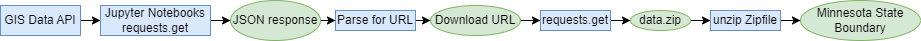

In [11]:
#location and name of downloaded zip file
current_directory = os.getcwd()
#path for downloaded zip
Mn_GeoName = os.path.join(current_directory, "MN_shape_data.zip")

#URL of API for minnesota state boundary
json_url = "https://gisdata.mn.gov/api/3/action/package_show?id=bdry-state-of-minnesota"

#perform the GET request to fetch the JSON data from the API
response = requests.get(json_url)

#check if the request was successful
if response.status_code == 200:
    #parse the JSON data from the response
    json_data = response.json()
    
    #the API gives us a new URL to directly download the data
    Mn_Geodataurl = json_data['result']['resources'][1]['url']
    
    #print the URL of the data that we are directly downloading from, provided by the API
    print(f"Target URL: {Mn_Geodataurl}")
else:
    print(f"Failed to fetch JSON data. Status code: {response.status_code}")

#getting URL and response is used for download
Mn_Georesult = requests.get(Mn_Geodataurl, stream=True)

#folder path for data extraction
Mn_Geofolder_new = os.path.join(current_directory, "MN_Shape_Data")
#if folder does not exist create folder
if not os.path.exists(Mn_Geofolder_new):
    os.mkdir(Mn_Geofolder_new)

#save zip and extract contents/ in write mode
with open(Mn_GeoName, 'wb') as file:
    shutil.copyfileobj(Mn_Georesult.raw, file)
#read in folder
with zipfile.ZipFile(Mn_GeoName, 'r') as zip_Mn_Geo:
    zip_Mn_Geo.extractall(Mn_Geofolder_new)
    
#opens current project
aprx = arcpy.mp.ArcGISProject("CURRENT")
#add the layer file to the current map
map_obj = aprx.activeMap
#add the specified layer file to map
map_obj.addDataFromPath(Mn_Geofolder_new + r'\Minnesota State Boundary.lyr')

Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/bdry_state_of_minnesota/fgdb_bdry_state_of_minnesota.zip


## Quality Assurance Quality Control Pipeline
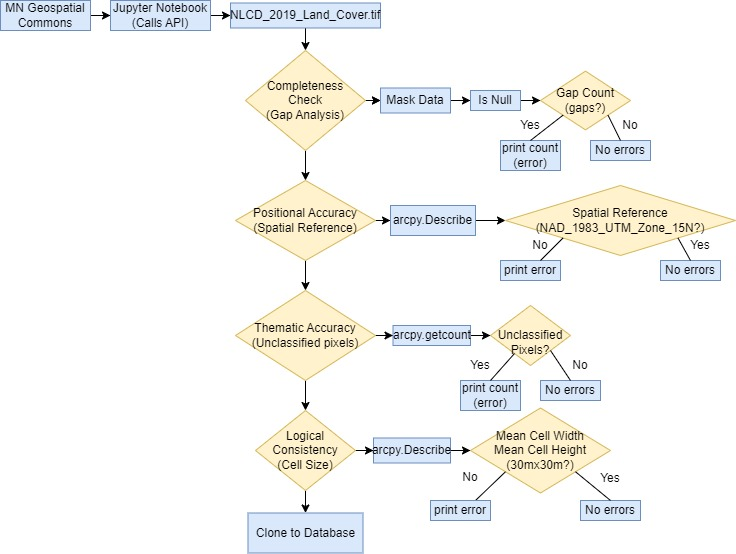

In [12]:
#path to Minnesota boundary
minnesota_boundary_path = r"../MN_Shape_Data/bdry_state_of_minnesota.gdb/state_of_minnesota"
#path to landcover dataset
raster_dataset_path = "NLCD_2019_Land_Cover.tif"

#convert minnesota boundary to a raster 
minnesota_mask_raster = "minnesota_mask.tif"
arcpy.conversion.PolygonToRaster(
    in_features=minnesota_boundary_path,
    value_field="OBJECTID",
    out_rasterdataset=minnesota_mask_raster,
    cell_assignment="MAXIMUM_AREA",
    priority_field="NONE",
    cellsize=raster_dataset_path,
    build_rat="BUILD"
)

#set NoData for areas outside Minnesota in the mask
minnesota_mask_raster_nodata = arcpy.ia.SetNull(minnesota_mask_raster, 1, "VALUE <> 1")

#apply the mask to raster dataset
raster_with_mask = "raster_mask.tif"
arcpy.env.mask = minnesota_mask_raster_nodata
#copy raster with applied mask
arcpy.CopyRaster_management(raster_dataset_path, raster_with_mask)

#completness: Ensure that landcover data covers the entire extent of Minnesota without gaps or missing values.
landcover_raster = raster_with_mask

#check for gaps in landcover data
gap_analysis = arcpy.sa.IsNull(landcover_raster)

#count the number of gaps in the landcover data
gap_count = arcpy.GetCount_management(gap_analysis)

#check if there are any gaps in the landcover data
if int(gap_count.getOutput(0)) > 0:
    print(gap_count.getOutput(0))
    print("Landcover data contains gaps.")
else:
    print("Landcover data is complete.")

1
Landcover data contains gaps.


In [13]:
#Positional Accuracy:
# Path to your TIFF file
tif_file = "NLCD_2019_Land_Cover.tif"

# Create a Describe object to get the spatial reference
desc = arcpy.Describe(tif_file)

# Get the spatial reference
spatial_ref = desc.spatialReference

# Print out the spatial reference
print("Spatial Reference Name: {}".format(spatial_ref.name))

# Check if the spatial reference name is "NAD_1983_UTM_Zone_15N"
if spatial_ref.name == "NAD_1983_UTM_Zone_15N":
    print("Data is good")
else:
    print("Data is bad")


Spatial Reference Name: NAD_1983_UTM_Zone_15N
Data is good


In [14]:
#thematic accuracy
#path to NLCD dataset
nlcd_file = "NLCD_2019_Land_Cover.tif"
#create a raster object
nlcd_raster = arcpy.Raster(nlcd_file)
#count the number of pixels with value 0 (unclassified items)
unclassified_pixels_count = arcpy.GetCount_management(nlcd_file).getOutput(0)
#print the count
print("Number of unclassified pixels (value 0) in NLCD dataset:", unclassified_pixels_count)

if int(unclassified_pixels_count) < 100:
    print('All good')
else:
    print('Error: not all good')

Number of unclassified pixels (value 0) in NLCD dataset: 16
All good


In [15]:
#logical Consistency (data structure)-- Landsat
#path to your NLCD raster dataset
nlcd_file = "NLCD_2019_Land_Cover.tif"

#create a Describe object to get properties of the dataset
desc = arcpy.Describe(nlcd_file)

#get the cell size
cell_width = desc.meanCellWidth
cell_height = desc.meanCellHeight

#print the cell size
print("Cell Size - Width: {} meters, Height: {} meters".format(cell_width, cell_height))

#check if the cell size is 30 by 30 meters
if cell_width == 30 and cell_height == 30:
    print("Data is good")
else:
    print("Data is bad")

Cell Size - Width: 30.0 meters, Height: 30.0 meters
Data is good
